In [109]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")

# df <- df[df$dataset != "cifar10",]
df <- df[df$dataset != "cifar100",]
df <- df[df$dataset != "imagenette",]

print(names(df))

  [1] "dataset"                                
  [2] "fgsm_20_ensemble_acc"                   
  [3] "fgsm_20_layer_accs.20"                  
  [4] "fgsm_20_layer_accs.30"                  
  [5] "fgsm_20_layer_accs.35"                  
  [6] "fgsm_20_layer_accs.40"                  
  [7] "fgsm_20_layer_accs.45"                  
  [8] "fgsm_20_layer_accs.50"                  
  [9] "fgsm_20_layer_accs.52"                  
 [10] "fgsm_30_ensemble_acc"                   
 [11] "fgsm_30_layer_accs.20"                  
 [12] "fgsm_30_layer_accs.30"                  
 [13] "fgsm_30_layer_accs.35"                  
 [14] "fgsm_30_layer_accs.40"                  
 [15] "fgsm_30_layer_accs.45"                  
 [16] "fgsm_30_layer_accs.50"                  
 [17] "fgsm_30_layer_accs.52"                  
 [18] "fgsm_35_ensemble_acc"                   
 [19] "fgsm_35_layer_accs.20"                  
 [20] "fgsm_35_layer_accs.30"                  
 [21] "fgsm_35_layer_accs.35"           

# plain

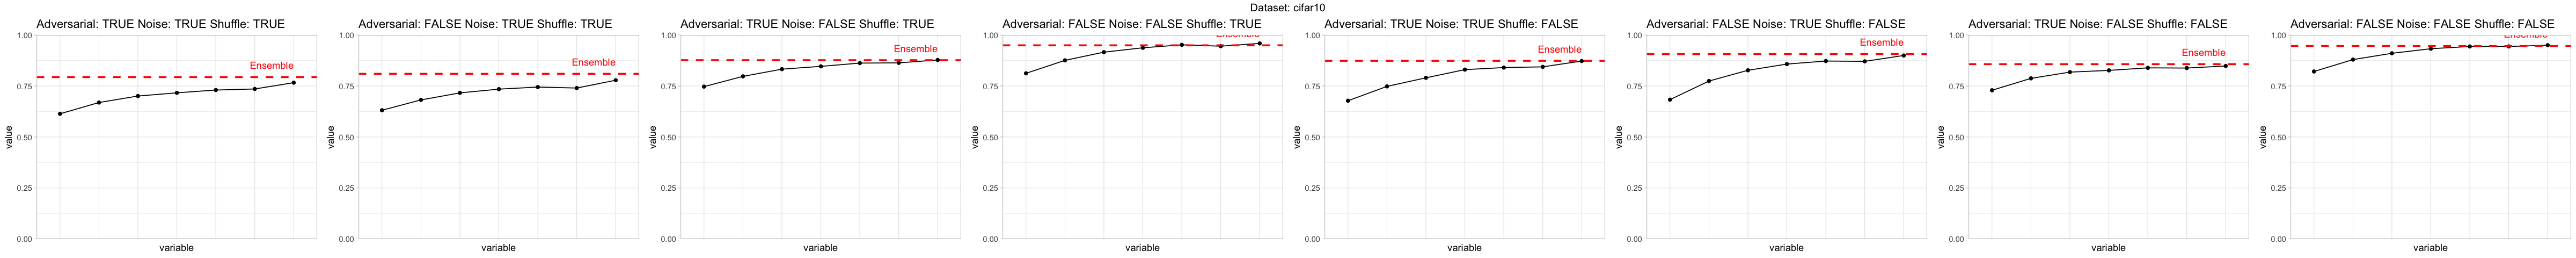

In [110]:
options(repr.plot.width=40, repr.plot.height=4)

acc_cols <- c("plain_layer_accs.20", "plain_layer_accs.30", "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", "plain_layer_accs.50", "plain_layer_accs.52")

for (ds in unique(df$dataset)) {
    df_ds <- df[df$dataset == ds,]

    plots <- list()
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                       df_ds$training_noise == combs$training_noise[i] &
                       df_ds$training_shuffle == combs$training_shuffle[i], ]
      
        melted_df <- melt(filtered_df, measure.vars = acc_cols)
      
        p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
            geom_line() +
            geom_point() +
            ggtitle(paste(
                "Adversarial:", combs$training_adversarial[i],
                "Noise:", combs$training_noise[i],
                "Shuffle:", combs$training_shuffle[i]
            )) +
            theme_light() +
            theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
            geom_hline(yintercept = filtered_df$plain_ensemble_acc[1], color = "red", linetype = "dashed", size = 1) +
            annotate("text", x = length(acc_cols), y = filtered_df$plain_ensemble_acc[1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1))

        plots[[i]] <- p
    }

    gridExtra::grid.arrange(grobs = plots, ncol = 8, top = paste("Dataset:", ds))
}

# fgsmensemble

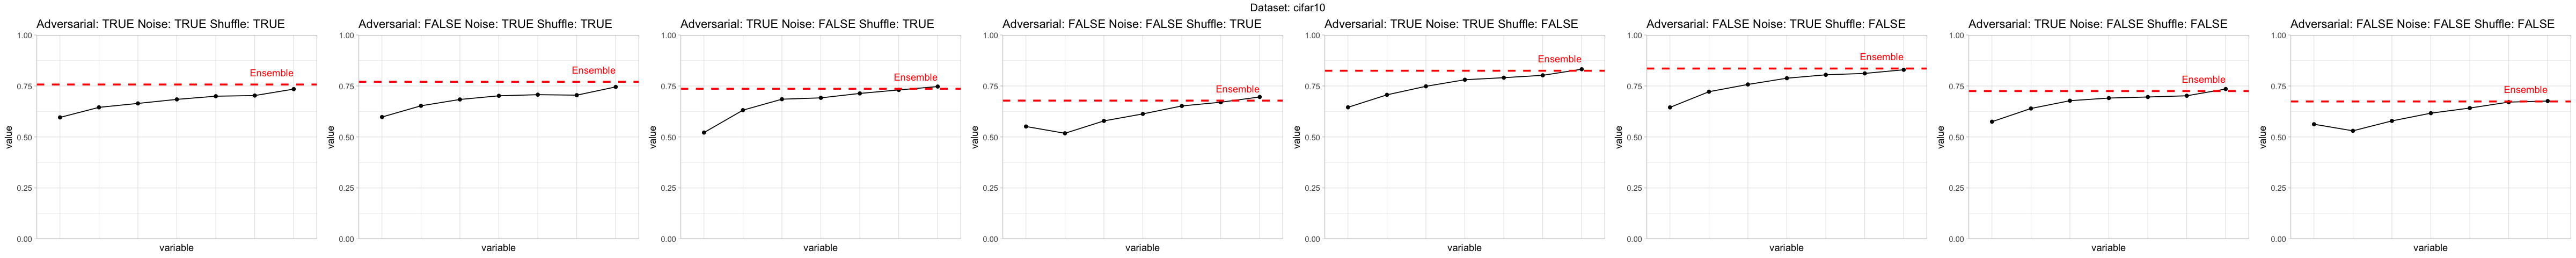

In [111]:
options(repr.plot.width=40, repr.plot.height=4)

acc_cols <- c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52")

for (ds in unique(df$dataset)) {
    df_ds <- df[df$dataset == ds,]

    plots <- list()
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                       df_ds$training_noise == combs$training_noise[i] &
                       df_ds$training_shuffle == combs$training_shuffle[i], ]
      
        melted_df <- melt(filtered_df, measure.vars = acc_cols)
      
        p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
            geom_line() +
            geom_point() +
            ggtitle(paste(
                "Adversarial:", combs$training_adversarial[i],
                "Noise:", combs$training_noise[i],
                "Shuffle:", combs$training_shuffle[i]
            )) +
            theme_light() +
            theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
            geom_hline(yintercept = filtered_df$fgsmensemble_ensemble_acc[1], color = "red", linetype = "dashed", size = 1) +
            annotate("text", x = length(acc_cols), y = filtered_df$fgsmensemble_ensemble_acc[1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1))

        plots[[i]] <- p
    }

    gridExtra::grid.arrange(grobs = plots, ncol = 8, top = paste("Dataset:", ds))
}

# fgsm20-52

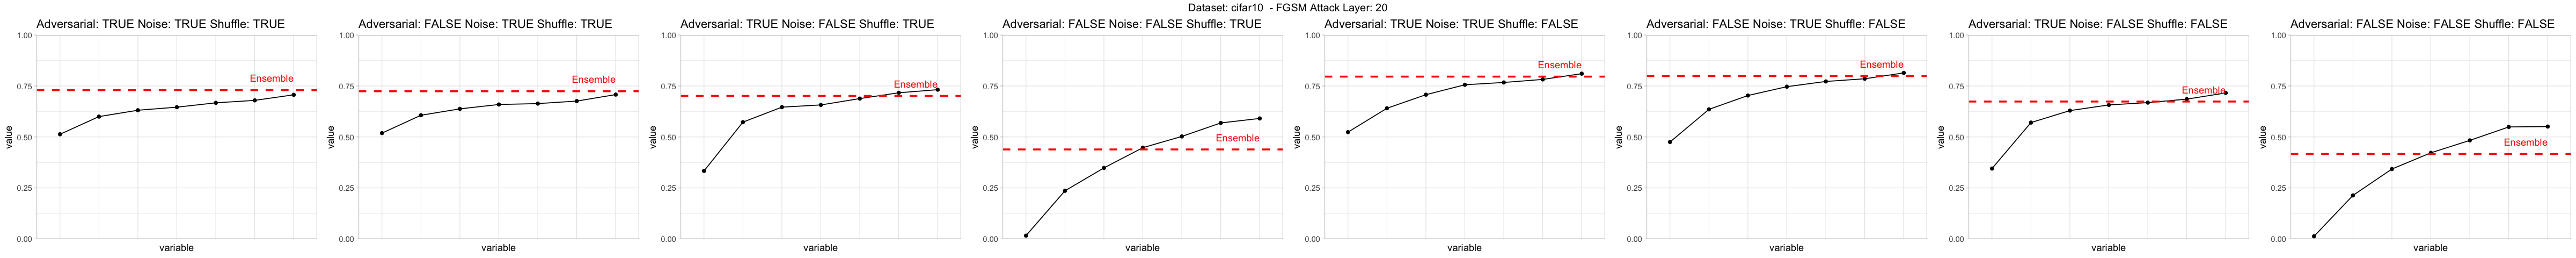

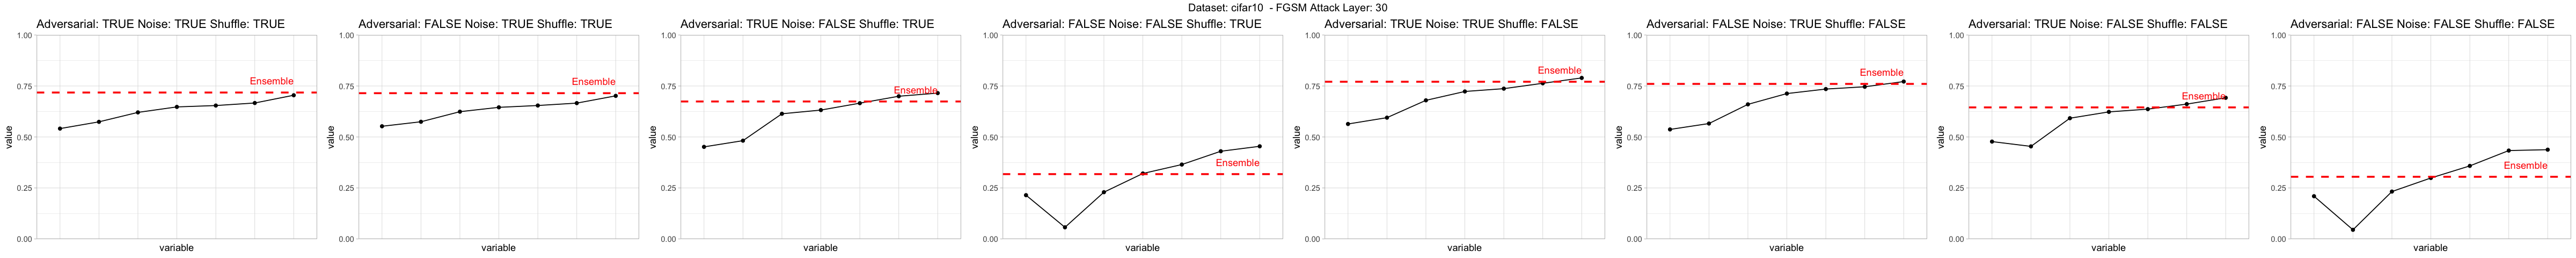

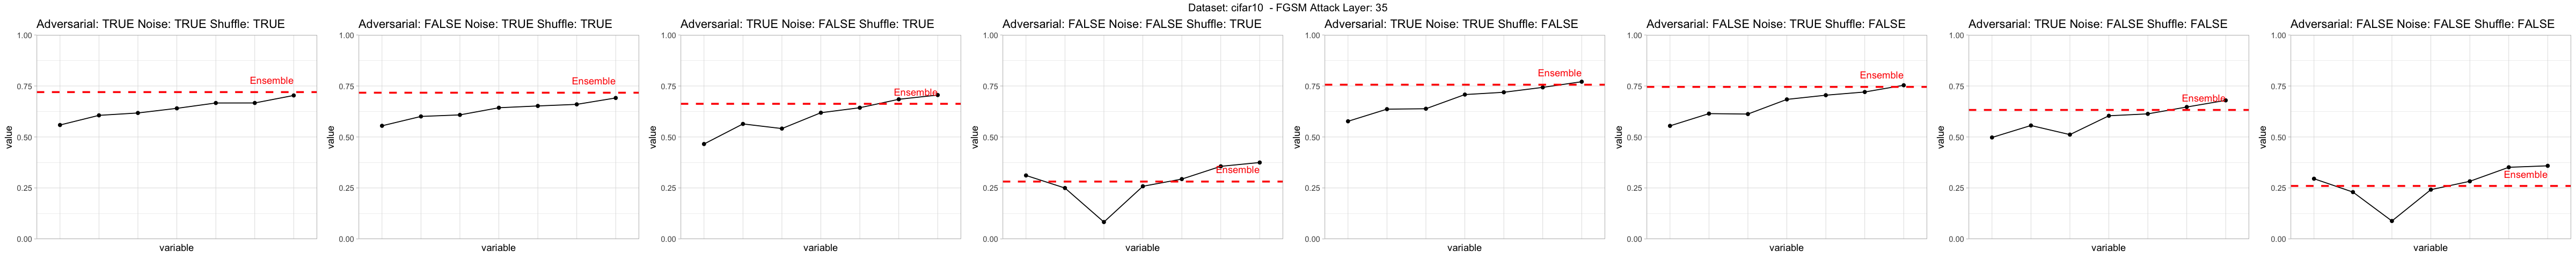

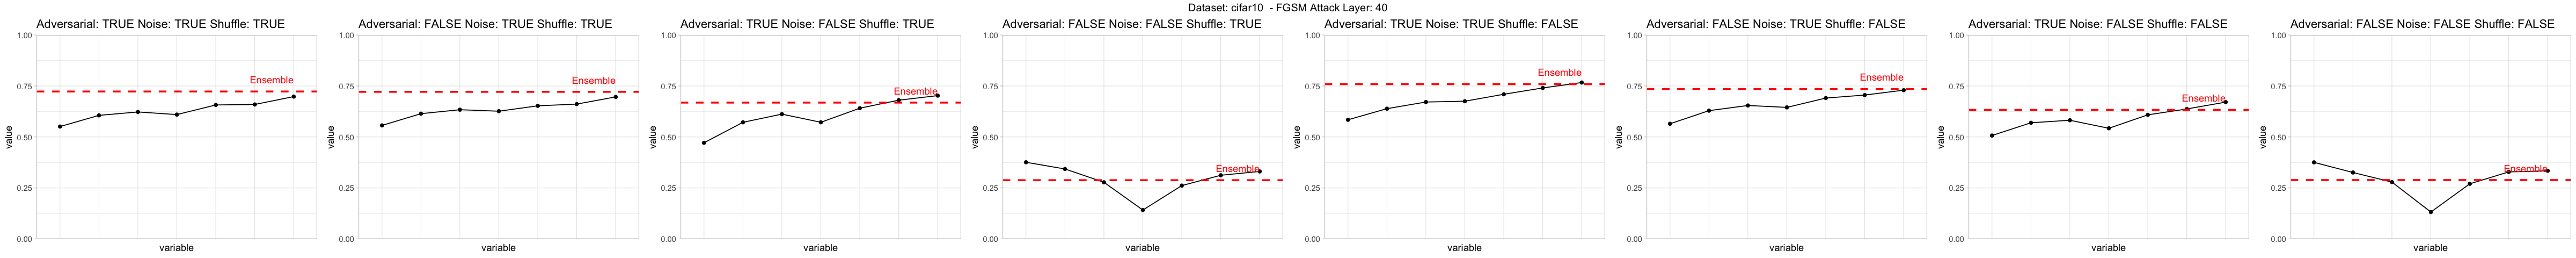

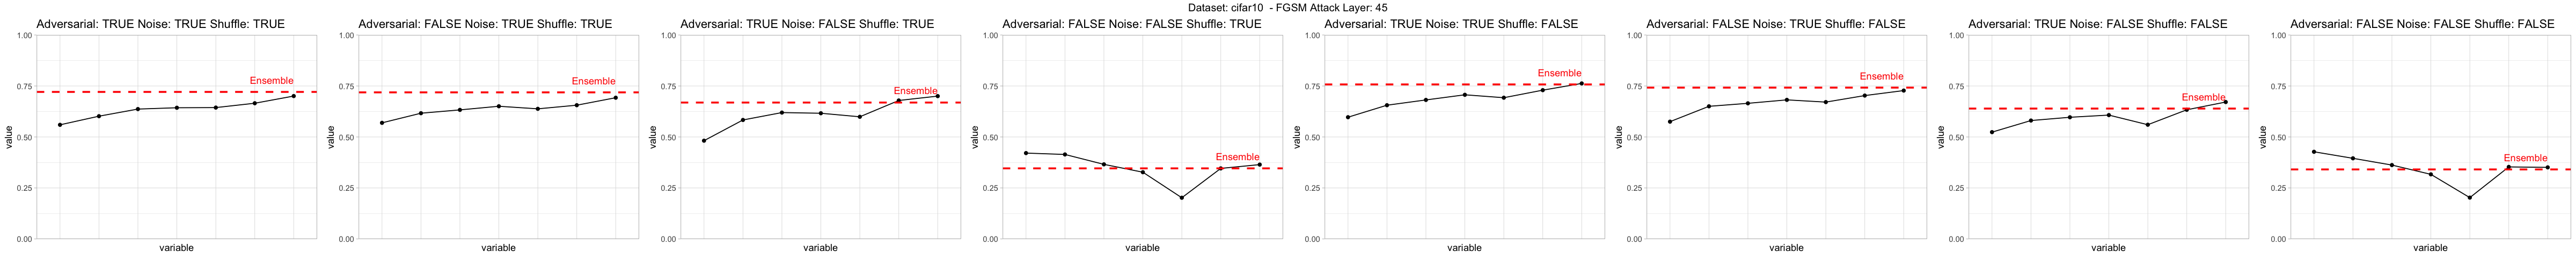

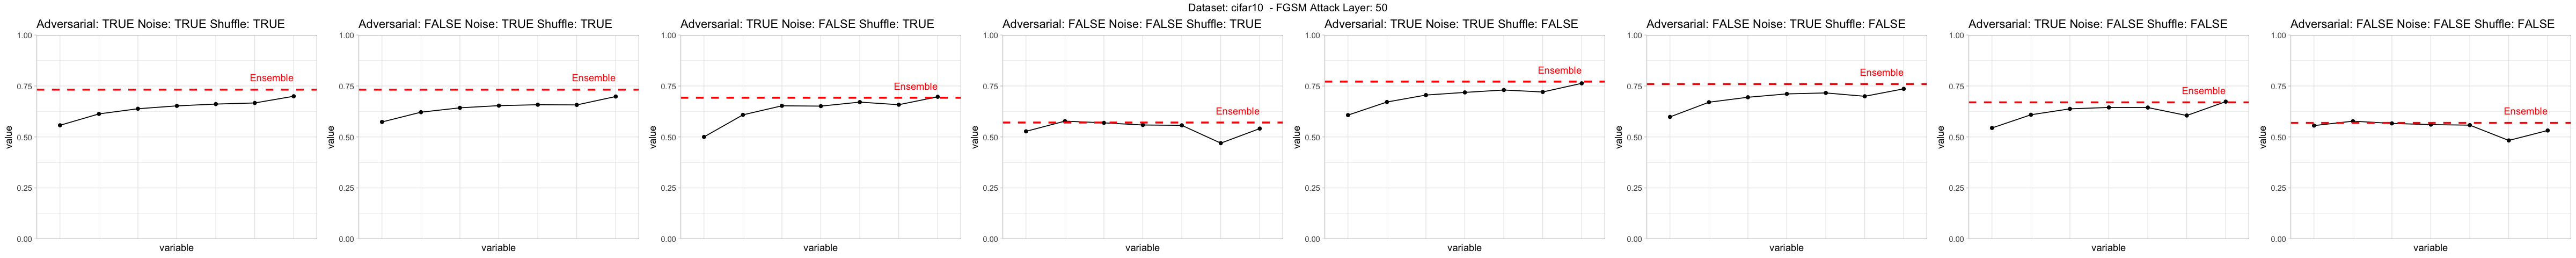

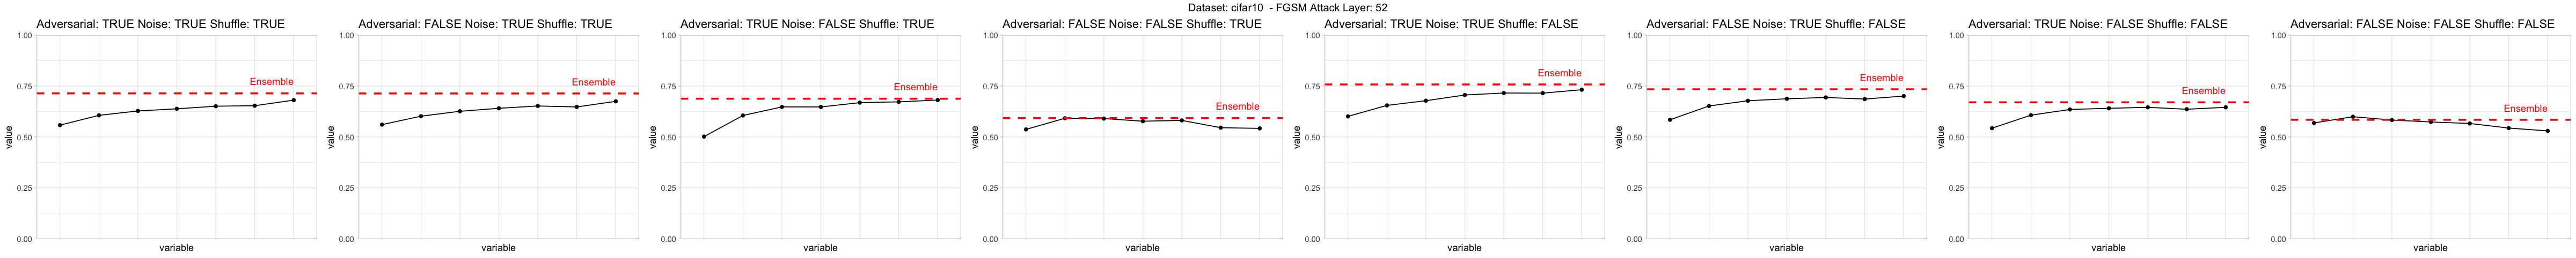

In [112]:
options(repr.plot.width=40, repr.plot.height=4)

layers <- c(20, 30, 35, 40, 45, 50, 52)

for (layer in layers) {

    acc_cols <- paste0("fgsm_", layer, "_layer_accs.", layers)
    ensemble_acc_col <- paste0("fgsm_", layer, "_ensemble_acc")

    for (ds in unique(df$dataset)) {
        df_ds <- df[df$dataset == ds,]

        plots <- list()
        combs <- expand.grid(
            training_adversarial = c(TRUE, FALSE),
            training_noise = c(TRUE, FALSE),
            training_shuffle = c(TRUE, FALSE)
        )
        for (i in 1:nrow(combs)) {
            filtered_df <- df_ds[df_ds$training_adversarial == combs$training_adversarial[i] &
                        df_ds$training_noise == combs$training_noise[i] &
                        df_ds$training_shuffle == combs$training_shuffle[i], ]
        
            melted_df <- melt(filtered_df, measure.vars = acc_cols)
        
            p <- ggplot(data = melted_df, aes(x = variable, y = value, group = 1)) +
                geom_line() +
                geom_point() +
                ggtitle(paste(
                    "Adversarial:", combs$training_adversarial[i],
                    "Noise:", combs$training_noise[i],
                    "Shuffle:", combs$training_shuffle[i]
                )) +
                theme_light() +
                theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
                geom_hline(yintercept = filtered_df[[ensemble_acc_col]][1], color = "red", linetype = "dashed", size = 1) +
                annotate("text", x = length(acc_cols), y = filtered_df[[ensemble_acc_col]][1], label = "Ensemble", color = "red", vjust = -1.2, hjust = 1) +
                scale_y_continuous(expand = c(0, 0), limits = c(0, 1))

            plots[[i]] <- p
        }

        gridExtra::grid.arrange(grobs = plots, ncol = 8, top = paste("Dataset:", ds, " - FGSM Attack Layer:", layer))
    }
}